In [122]:
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.animation as animation
import glob
import re


path_tde_sergeiElite = "/home/matias/Simulations/mi_fargo3d/outputs/tde_2d_ad_sergei/" # frame 100
path_tde_segei_imac_5Mj = "/Users/matias/Simulations/mi_fargo3d/outputs/tde_2d_ad_sergei/"
path_tde_segei_imac_1Mj = "/Users/matias/Simulations/mi_fargo3d/outputs/tde_2d_ad_sergei_1MJ/"

path = path_tde_segei_imac_1Mj

# Identificar el número de outputs disponibles
# Patrón para archivos gasdens*.dat con un número entero
pattern = re.compile(r'gasdens(\d+)\.dat')
# Lista de archivos que coinciden con el patrón gasdens*.dat
files = glob.glob(path + "gasdens*.dat")
# Filtrar archivos que se ajustan al patrón correcto
valid_files = [f for f in files if pattern.match(os.path.basename(f))]
# Contar el número de archivos válidos
Ntot = len(valid_files)
print("En total hay: ", Ntot, "outputs")
#UNITS
gamma=1.6666
mu=2.35 #
kb=1.380650424e-16 #ergs/K
R_gas=8.314472e7 #erg/K/mol 
G = 6.67259e-8 #cm**3 g**-1 s**-2
mp= 1.672623099e-24 # g
sigma_sb = 5.670374419e-5 # Stefan-Boltzmann constant [erg cm^-2 s^-1 K^-4]
L_sun_cgs = 3.828e33      # Solar luminosity [erg/s]

unit_mass   = 1.9891e33 # g
unit_length = 1.49598e13 #cm
unit_density=(unit_mass)/(unit_length**3) # g/cm**3
unit_surf_density = (unit_mass/unit_length**2) # g/cm**2
unit_time     = np.sqrt( pow(unit_length,3.) / G / unit_mass) #s 
unit_energy   = unit_mass/(unit_time)**2/(unit_length)  #erg/cm3 = gr/s2/cm  #juan garrido
unit_surf_energy = unit_energy / unit_length
unit_velocity = unit_length / unit_time  # cm/s

unit_temperature  = ((G*mp*mu)/(kb))*(unit_mass/(unit_length)) #K


variables_par = np.genfromtxt(path+"/variables.par",dtype={'names': ("parametros","valores"),'formats': ("|S30","|S300")}).tolist()#Lee archivo var    iable.pary convierte a string       esita un int o float
parametros_par, valores_par = [],[]                                                                                                                                                                                                                         #Reparte entre parametros y valores
for posicion in variables_par:                                                                                                                                                                                                                              #
        parametros_par.append(posicion[0].decode("utf-8"))                                                                                                                                                                                  #
        valores_par.append(posicion[1].decode("utf-8"))                                                                                                                                                                                     #

def P(parametro):
        return valores_par[parametros_par.index(parametro)] 



def compute_accretion_rate(output_number, path, r0):
    """
    Calcula la tasa de acreción en el radio r0 para un output_number dado.

    Parámetros:
    - output_number: número del output (snapshot) de la simulación.
    - path: ruta al directorio donde están los datos de la simulación.
    - r0: radio seleccionado donde calcular la tasa de acreción (en unidades de AU).

    Retorna:
    - accretion_rate: tasa de acreción en unidades de masas solares por año (Msun/yr).
    """

    # Cargar los datos de densidad superficial (gasdens) y velocidad radial (gasvy)
    dens_data = np.fromfile(path + f"gasdens{output_number}.dat").reshape(NY, NX) * unit_surf_density  # [g/cm^2]
    vr_data = np.fromfile(path + f"gasvy{output_number}.dat").reshape(NY, NX) * unit_velocity  # [cm/s]

    # Obtener el radio y ángulo azimutal en cada celda
    Phi = 0.5 * (domain_x[1:] + domain_x[:-1])  # [rad]
    R = 0.5 * (domain_y[1:] + domain_y[:-1])    # [AU]

    # Si la malla es uniforme en phi
    Delta_phi = 2 * np.pi / NX  # [rad]

    # Encontrar el índice radial más cercano a r0
    radial_index = np.argmin(np.abs(R - r0))
    r_selected = R[radial_index] * unit_length  # Convertir a [cm]

    # Extraer densidad y velocidad radial en el radio seleccionado
    Sigma_r = dens_data[radial_index, :]  # [g/cm^2]
    vr_r = vr_data[radial_index, :]       # [cm/s]

    # Calcular el flujo de masa en cada celda azimutal
    mass_flux = -Sigma_r * vr_r * r_selected * Delta_phi  # [g/s]
    

    # Sumar sobre todas las celdas azimutales para obtener la tasa de acreción total
    accretion_rate = np.sum(mass_flux)  # [g/s]

    # Convertir la tasa de acreción a unidades de masas solares por año
    accretion_rate_msun_per_year = accretion_rate * (3.154e7) / 1.989e33  # [Msun/yr]

    return accretion_rate_msun_per_year




# construyendo la grilla
Ninter = int(P("NINTERM"))
DT = float(P("DT"))

# Cargar la grilla de la simulación
domain_x = np.genfromtxt(path + "domain_x.dat")
domain_y = np.genfromtxt(path + "domain_y.dat")[3:-3]

NX = int(P("NX"))# len(domain_x) - 1
NY = int(P("NY")) #len(domain_y) - 1


output_number = 1
r0 = 1
mdot = compute_accretion_rate(output_number, path, r0)
output_numbers = range(Ntot)
print(f"Tasa de acreción en r = {r0} AU: {mdot:.3e} M☉/año")


En total hay:  101 outputs
Tasa de acreción en r = 1 AU: 1.782e-04 M☉/año


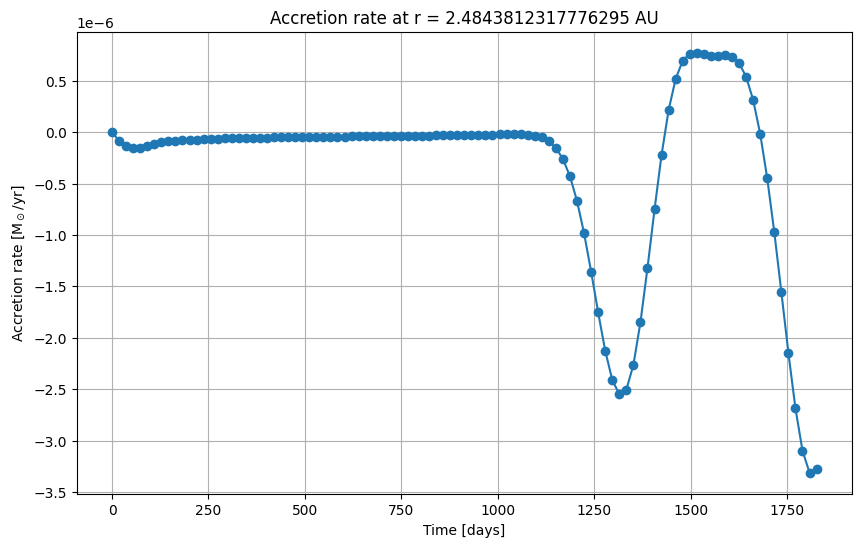

In [121]:
# Lista para almacenar la tasa de acreción y los tiempos
mdot_list = []
time_list = []

# Calcula la tasa de acreción para cada output
for output_number in output_numbers:
    # Tiempo en unidades de código
    time_code_units = output_number * Ninter * DT
    # Convertir el tiempo a segundos y luego a días
    time_days = time_code_units * unit_time / 86400  # Tiempo en días
    # Calcular la tasa de acreción
    mdot = compute_accretion_rate(output_number, path, r0)
    mdot_list.append(mdot)
    time_list.append(time_days)

# Convertir listas a arrays para facilitar el manejo
mdot_array = np.array(mdot_list)
time_array = np.array(time_list)

# Grafica la tasa de acreción en función del tiempo (en días)
plt.figure(figsize=(10, 6))
plt.plot(time_array, mdot_array, marker='o')
plt.xlabel('Time [days]')
plt.ylabel('Accretion rate [M$_\odot$/yr]')
plt.title(f'Accretion rate at r = {r0} AU')
plt.grid(True)
plt.show()


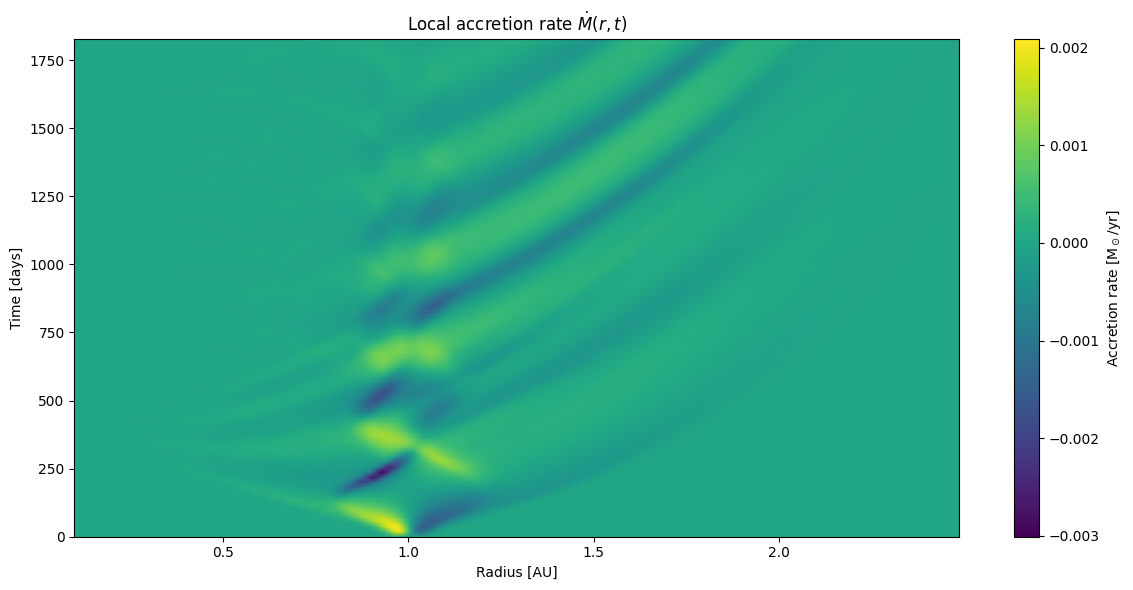

In [123]:
# Create an array of radii
radii =  0.5 * (domain_y[1:] + domain_y[:-1])  # np.linspace(r_min, r_max, num_radii)  # [AU]
num_radii = NY
# Assuming 'output_numbers' and 'time_array' are already defined
# output_numbers = range(Ntot)
# time_array = [...]  # Calculated or existing time array in days

# Initialize a matrix to store \dot{M}(r, t)
mdot_matrix = np.zeros((len(time_array), num_radii))  # Dimensions: time x radius

# Loop over times (outputs)
for i, output_number in enumerate(output_numbers):
    # Optional: print progress
    #print(f"Processing output {output_number + 1} of {Ntot}")
    
    # Loop over radii
    for j, r0 in enumerate(radii):
        # Calculate the accretion rate at radius r0 and time t
        mdot = compute_accretion_rate(output_number, path, r0)
        # Store in the matrix
        mdot_matrix[i, j] = mdot


# Generate the plot of \dot{M}(r, t) as a heatmap
# Create a meshgrid of radii and times for plotting
R, T = np.meshgrid(radii, time_array)  # R in [AU], T in [days]

# Create the figure and axis
plt.figure(figsize=(12, 6))

# Use pcolormesh for the heatmap
plt.pcolormesh(R, T, mdot_matrix, shading='gouraud', cmap='viridis')

# Add a color bar
cbar = plt.colorbar()
cbar.set_label('Accretion rate [M$_\odot$/yr]')  # Color bar label in English

# Labels and title in English
plt.xlabel('Radius [AU]')
plt.ylabel('Time [days]')
plt.title('Local accretion rate $\dot{M}(r, t)$')

# Optionally adjust the limits of the plot
plt.xlim(radii.min(), radii.max())
plt.ylim(time_array.min(), time_array.max())

# Show the plot
plt.tight_layout()
plt.show()


Processing output 1 of 101 for time 0.0 days
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.

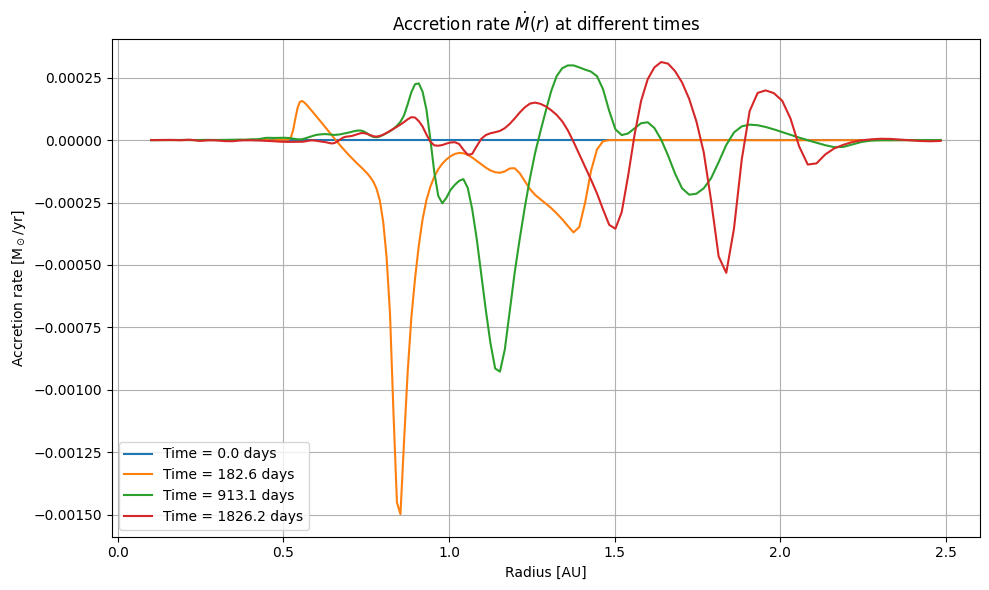

In [115]:
############
# plot de Mdot(r) para tistintos tiempos
###########
# Seleccionar los tiempos (outputs) en los que deseas graficar \dot{M}(r)
# Por ejemplo, puedes seleccionar 3 tiempos: al inicio, a la mitad y al final de la simulación
selected_outputs = [0, 10, 50, 100]  # Puedes ajustar estos valores

# Crear una lista con los tiempos correspondientes en días
selected_times = []
for output_number in selected_outputs:
    time_code_units = output_number * Ninter * DT
    time_days = time_code_units * unit_time / 86400  # Tiempo en días
    selected_times.append(time_days)

# Crear un array de radios
radii =  0.5 * (domain_y[1:] + domain_y[:-1])  # [AU] 
# Inicializar una lista para almacenar las curvas de \dot{M}(r) en los tiempos seleccionados
mdot_curves = []

# Bucle sobre los outputs seleccionados
for idx, output_number in enumerate(selected_outputs):
    # Opcional: imprimir el progreso
    print(f"Processing output {output_number + 1} of {Ntot} for time {selected_times[idx]:.1f} days")
    
    # Inicializar un array para \dot{M}(r) en este tiempo
    mdot_r = []
    # Bucle sobre los radios
    for r0 in radii:
        # Calcular la tasa de acreción en el radio r0 y tiempo t
        mdot = compute_accretion_rate(output_number, path, r0)
        mdot_r.append(mdot)
    # Agregar la curva a la lista
    mdot_curves.append(mdot_r)

# Graficar las curvas de \dot{M}(r) para los tiempos seleccionados
plt.figure(figsize=(10, 6))

for i, mdot_r in enumerate(mdot_curves):
    plt.plot(radii, mdot_r, label=f'Time = {selected_times[i]:.1f} days')

plt.xlabel('Radius [AU]')
plt.ylabel('Accretion rate [M$_\odot$/yr]')
plt.title('Accretion rate $\dot{M}(r)$ at different times')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



At time 0.0 days, \dot{M} is zero or negative at all radii.


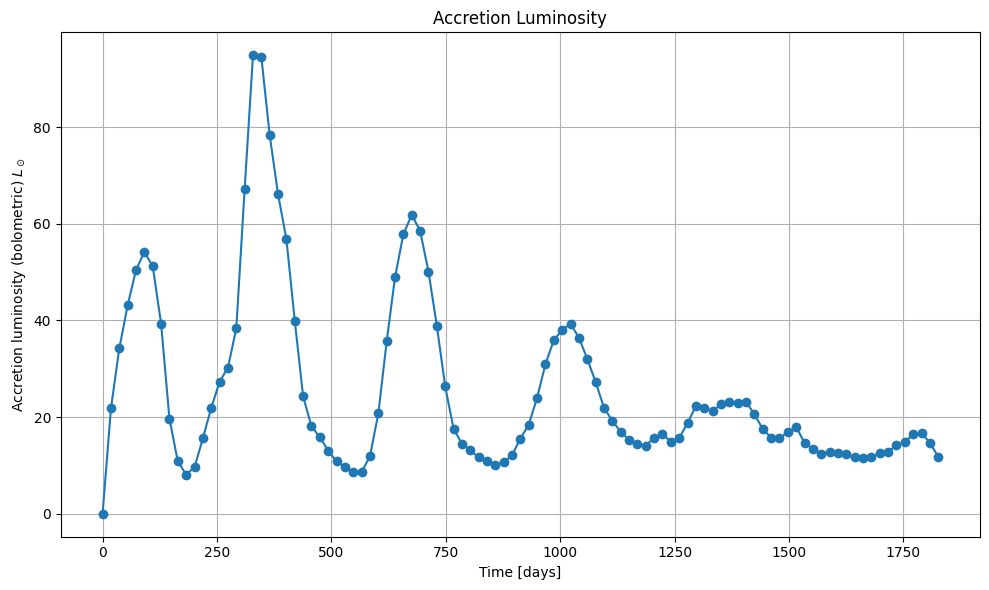

In [101]:
##
### Calculo de la luminosidad de acrecion

# Parámetros del objeto central y constantes
M_star = 1.0  # Masa del objeto central en masas solares
M_star_cgs = M_star * 1.989e33  # Convertir a gramos
G_cgs = 6.67430e-8  # Constante de gravitación universal en cm^3 g^-1 s^-2
L_sun_cgs = 3.828e33  # Luminosidad solar en erg/s
M_sun = 4.83  # Magnitud absoluta del Sol en la banda V

# Convertir radios a cm
radii_cm = radii * unit_length  # unit_length en cm

# Cálculo de la luminosidad total y su conversión a magnitudes
time_array_L = []
L_total_Lsun = []
M_total = []

for idx, output_number in enumerate(output_numbers):
    # Calcular el tiempo correspondiente
    time_code_units = output_number * Ninter * DT
    time_days = time_code_units * unit_time / 86400  # Tiempo en días
    time_array_L.append(time_days)
    
    # Calcular \dot{M}(r, t)
    mdot_r = []
    for r0 in radii:
        mdot = compute_accretion_rate(output_number, path, r0)
        mdot_r.append(mdot)
    mdot_r = np.array(mdot_r)
    
    # Convertir \dot{M} a g/s
    mdot_r_cgs = mdot_r * (1.989e33) / (3.154e7)  # g/s
    
    # Establecer a cero los valores negativos de \dot{M}
    mdot_r_cgs = np.where(mdot_r_cgs > 0, mdot_r_cgs, 0.0)
    
    # Verificar si \dot{M} es cero en todos los radios
    if np.all(mdot_r_cgs == 0):
        print(f"At time {time_days:.1f} days, \dot{{M}} is zero or negative at all radii.")
        L_total_Lsun_value = 0.0
        M = np.nan  # O asignar un valor muy grande
    else:
        # Calcular dL/dr
        dLdr = (3 * G_cgs * M_star_cgs * mdot_r_cgs) / (2 * (radii_cm ** 2))  # erg/s/cm
        
        # Integrar para obtener L_total
        L_total = np.trapz(dLdr, radii_cm)  # erg/s
        L_total_Lsun_value = L_total / L_sun_cgs  # Convertir a L_sun
        
        # Calcular la magnitud absoluta
        M = M_sun - 2.5 * np.log10(L_total_Lsun_value) + 17.0
    
    # Almacenar los valores
    L_total_Lsun.append(L_total_Lsun_value)
    M_total.append(M)

# Convertir listas a arrays numpy
time_array_L = np.array(time_array_L)
L_total_Lsun = np.array(L_total_Lsun)
M_total = np.array(M_total)

# Graficar la magnitud absoluta vs. tiempo
plt.figure(figsize=(10, 6))
plt.plot(time_array_L, L_total_Lsun, marker='o')
plt.xlabel('Time [days]')
#plt.ylabel('Absolute Magnitude $M$')
plt.ylabel('Accretion luminosity (bolometric) $L_\odot$')
plt.title('Accretion Luminosity')
#plt.gca().invert_yaxis()  # Invertir eje Y
plt.grid(True)
plt.tight_layout()
plt.show()



At time 0.0 days, \dot{M} is zero or negative at all radii.


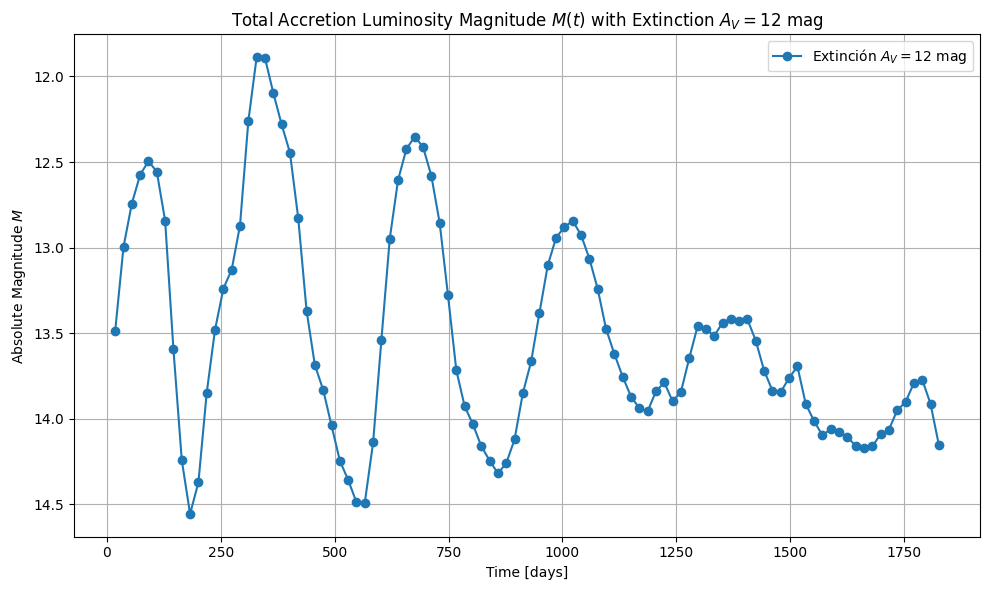

In [104]:
### calculo de la luminosidad con extincion Av = 17 mag
# Definir la extinción en la banda V
# Definir la extinción en la banda V
A_V = 12  # magnitudes

# Parámetros del objeto central y constantes
M_sun = 4.83  # Magnitud absoluta del Sol en la banda V

# Inicializar listas para almacenar los resultados
time_array_L = []
L_total_Lsun = []
M_total = []

for idx, output_number in enumerate(output_numbers):
    # Calcular el tiempo correspondiente
    time_code_units = output_number * Ninter * DT
    time_days = time_code_units * unit_time / 86400  # Tiempo en días
    time_array_L.append(time_days)
    
    # Calcular \dot{M}(r, t)
    mdot_r = []
    for r0 in radii:
        mdot = compute_accretion_rate(output_number, path, r0)
        mdot_r.append(mdot)
    mdot_r = np.array(mdot_r)
    
    # Convertir \dot{M} a g/s
    mdot_r_cgs = mdot_r * (1.989e33) / (3.154e7)  # g/s
    
    # Establecer a cero los valores negativos de \dot{M}
    mdot_r_cgs = np.where(mdot_r_cgs > 0, mdot_r_cgs, 0.0)
    
    # Verificar si \dot{M} es cero en todos los radios
    if np.all(mdot_r_cgs == 0):
        print(f"At time {time_days:.1f} days, \dot{{M}} is zero or negative at all radii.")
        L_total_Lsun_value = 0.0
        M_obs = np.nan  # Definir M_obs como NaN
    else:
        # Calcular dL/dr
        dLdr = (3 * G_cgs * M_star_cgs * mdot_r_cgs) / (2 * (radii_cm ** 2))  # erg/s/cm
        
        # Integrar para obtener L_total
        L_total = np.trapz(dLdr, radii_cm)  # erg/s
        L_total_Lsun_value = L_total / L_sun_cgs  # Convertir a L_sun
        
        # Calcular la magnitud absoluta intrínseca
        M_intrinsec = M_sun - 2.5 * np.log10(L_total_Lsun_value)
        
        # Calcular la magnitud observada con extinción
        M_obs = M_intrinsec + A_V
    
    # Almacenar los valores
    L_total_Lsun.append(L_total_Lsun_value)
    M_total.append(M_obs)


# Convertir listas a arrays numpy
time_array_L = np.array(time_array_L)
L_total_Lsun = np.array(L_total_Lsun)
M_total = np.array(M_total)

# Graficar la magnitud absoluta total vs. tiempo con extinción
plt.figure(figsize=(10, 6))
plt.plot(time_array_L, M_total, marker='o', label=f'Extinción $A_V={A_V}$ mag')
plt.xlabel('Time [days]')
plt.ylabel('Absolute Magnitude $M$')
plt.title(f'Total Accretion Luminosity Magnitude $M(t)$ with Extinction $A_V={A_V}$ mag')
plt.gca().invert_yaxis()  # Invertir eje Y para que magnitudes más bajas (más brillantes) estén arriba
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


At time 0.0 days, \dot{M} is zero or negative at all radii.


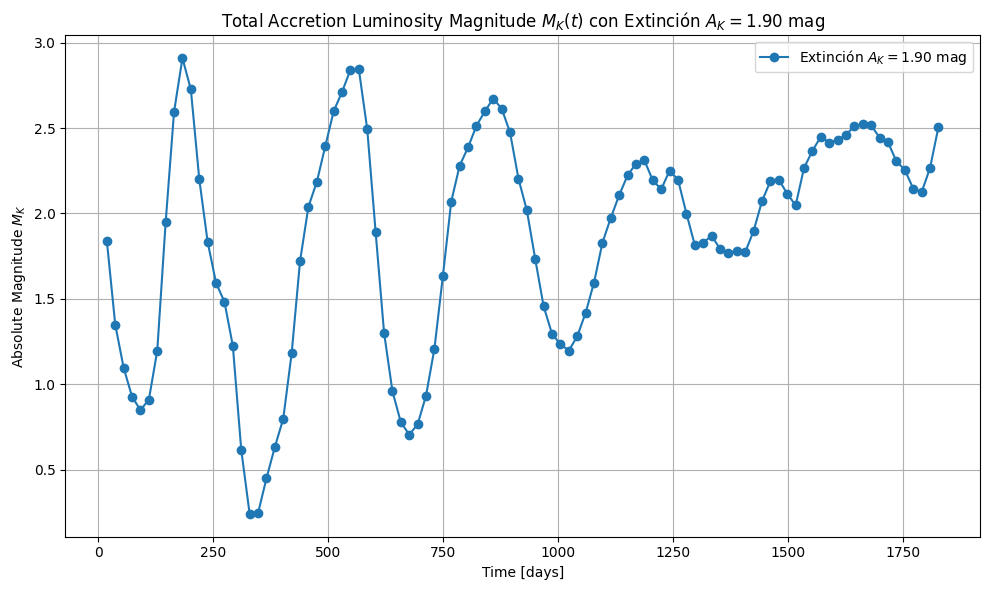

In [93]:
### ahora hacemos una correccion de la magnitud a la banda K
##

# Definir la extinción en la banda V
A_V = 17.0  # magnitudes

# Calcular la extinción en la banda K usando una ley de extinción estándar
A_K = 0.112 * A_V  # magnitudes

# Magnitud absoluta del Sol en la banda K
M_sun_K = 3.28  # magnitud absoluta del Sol en la banda K

# Inicializar listas para almacenar los resultados
time_array_L = []
L_total_Lsun = []
M_total_K = []

for idx, output_number in enumerate(output_numbers):
    # Calcular el tiempo correspondiente
    time_code_units = output_number * Ninter * DT
    time_days = time_code_units * unit_time / 86400  # Tiempo en días
    time_array_L.append(time_days)
    
    # Calcular \dot{M}(r, t)
    mdot_r = []
    for r0 in radii:
        mdot = compute_accretion_rate(output_number, path, r0)
        mdot_r.append(mdot)
    mdot_r = np.array(mdot_r)
    
    # Convertir \dot{M} a g/s
    mdot_r_cgs = mdot_r * (1.989e33) / (3.154e7)  # g/s
    
    # Establecer a cero los valores negativos de \dot{M}
    mdot_r_cgs = np.where(mdot_r_cgs > 0, mdot_r_cgs, 0.0)
    
    # Verificar si \dot{M} es cero en todos los radios
    if np.all(mdot_r_cgs == 0):
        print(f"At time {time_days:.1f} days, \dot{{M}} is zero or negative at all radii.")
        L_total_Lsun_value = 0.0
        M_obs_K = np.nan  # Magnitud indefinida o extremadamente débil
    else:
        # Calcular dL/dr
        dLdr = (3 * G_cgs * M_star_cgs * mdot_r_cgs) / (2 * (radii_cm ** 2))  # erg/s/cm
        
        # Integrar para obtener L_total
        L_total = np.trapz(dLdr, radii_cm)  # erg/s
        L_total_Lsun_value = L_total / L_sun_cgs  # Convertir a L_sun
        
        # Calcular la magnitud absoluta intrínseca en la banda K
        M_intrinsec_K = M_sun_K - 2.5 * np.log10(L_total_Lsun_value)
        
        # Calcular la magnitud observada con extinción en la banda K
        M_obs_K = M_intrinsec_K + A_K
    
    # Almacenar los valores
    L_total_Lsun.append(L_total_Lsun_value)
    M_total_K.append(M_obs_K)

# Convertir listas a arrays numpy
time_array_L = np.array(time_array_L)
L_total_Lsun = np.array(L_total_Lsun)
M_total_K = np.array(M_total_K)

# Graficar la magnitud absoluta total vs. tiempo con extinción en la banda K
plt.figure(figsize=(10, 6))
plt.plot(time_array_L, M_total_K, marker='o', label=f'Extinción $A_K={A_K:.2f}$ mag')
plt.xlabel('Time [days]')
plt.ylabel('Absolute Magnitude $M_K$')
plt.title('Total Accretion Luminosity Magnitude $M_K(t)$ con Extinción $A_K=1.90$ mag')
#plt.gca().invert_yaxis()  # Invertir eje Y para que magnitudes más bajas (más brillantes) estén arriba
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


At time 0.0 days, \dot{M} is zero or negative at all radii.


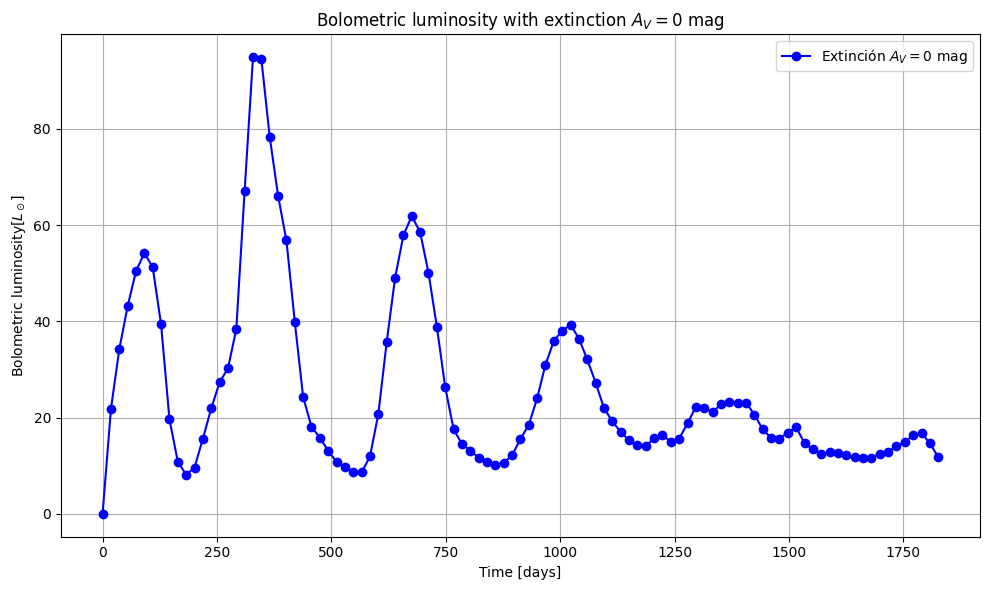

In [109]:
## calculo de la luminosidad considerando extincion
# Definir la extinción en la banda V
A_V = 0  # magnitudes

# Definir la función para aplicar la extinción
def calcular_luminosidad_observada(Lbol, A_v):
    """
    Calcula la luminosidad bolométrica observada considerando la extinción Av.

    Parámetros:
    - Lbol: array o valor de luminosidades bolométricas [L_sun]
    - A_v: extinción en magnitudes

    Retorna:
    - Lbol_obs: luminosidad bolométrica observada [L_sun]
    """
    return Lbol * 10**(-0.4 * A_v)

# Inicializar listas para almacenar los resultados
time_array_L = []
L_total_Lsun = []
L_total_Lsun_obs = []  # Nueva lista para luminosidad observada

for idx, output_number in enumerate(output_numbers):
    # Calcular el tiempo correspondiente
    time_code_units = output_number * Ninter * DT
    time_days = time_code_units * unit_time / 86400  # Tiempo en días
    time_array_L.append(time_days)
    
    # Calcular \dot{M}(r, t)
    mdot_r = []
    for r0 in radii:
        mdot = compute_accretion_rate(output_number, path, r0)
        mdot_r.append(mdot)
    mdot_r = np.array(mdot_r)
    
    # Convertir \dot{M} a g/s
    mdot_r_cgs = mdot_r * (1.989e33) / (3.154e7)  # g/s
    
    # Establecer a cero los valores negativos de \dot{M}
    mdot_r_cgs = np.where(mdot_r_cgs > 0, mdot_r_cgs, 0.0)
    
    # Verificar si \dot{M} es cero en todos los radios
    if np.all(mdot_r_cgs == 0):
        print(f"At time {time_days:.1f} days, \dot{{M}} is zero or negative at all radii.")
        L_total_Lsun_value = 0.0
    else:
        # Calcular dL/dr
        dLdr = (3 * G_cgs * M_star_cgs * mdot_r_cgs) / (2 * (radii_cm ** 2))  # erg/s/cm
        
        # Integrar para obtener L_total
        L_total = np.trapz(dLdr, radii_cm)  # erg/s
        L_total_Lsun_value = L_total / L_sun_cgs  # Convertir a L_sun

    # Almacenar la luminosidad total
    L_total_Lsun.append(L_total_Lsun_value)
    
    # Calcular la luminosidad observada con extinción
    L_obs = calcular_luminosidad_observada(L_total_Lsun_value, A_V)
    L_total_Lsun_obs.append(L_obs)

# Convertir listas a arrays numpy
time_array_L = np.array(time_array_L)
L_total_Lsun_obs = np.array(L_total_Lsun_obs)

# Graficar la luminosidad bolométrica observada vs. tiempo
plt.figure(figsize=(10, 6))
plt.plot(time_array_L, L_total_Lsun_obs, marker='o', color='blue', label=f'Extinción $A_V={A_V}$ mag')
plt.xlabel('Time [days]')
plt.ylabel('Bolometric luminosity[$L_\\odot$]')
plt.title(f'Bolometric luminosity with extinction $A_V={A_V}$ mag')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Procesando output 1 de 101 para tiempo 0.0 días
Procesando output 2 de 101 para tiempo 18.3 días
Procesando output 3 de 101 para tiempo 36.5 días
Procesando output 4 de 101 para tiempo 54.8 días
Procesando output 5 de 101 para tiempo 73.0 días
Procesando output 6 de 101 para tiempo 91.3 días
Procesando output 7 de 101 para tiempo 109.6 días
Procesando output 8 de 101 para tiempo 127.8 días
Procesando output 9 de 101 para tiempo 146.1 días
Procesando output 10 de 101 para tiempo 164.4 días
Procesando output 11 de 101 para tiempo 182.6 días
Procesando output 12 de 101 para tiempo 200.9 días
Procesando output 13 de 101 para tiempo 219.1 días
Procesando output 14 de 101 para tiempo 237.4 días
Procesando output 15 de 101 para tiempo 255.7 días
Procesando output 16 de 101 para tiempo 273.9 días
Procesando output 17 de 101 para tiempo 292.2 días
Procesando output 18 de 101 para tiempo 310.5 días
Procesando output 19 de 101 para tiempo 328.7 días
Procesando output 20 de 101 para tiempo 347.0 d

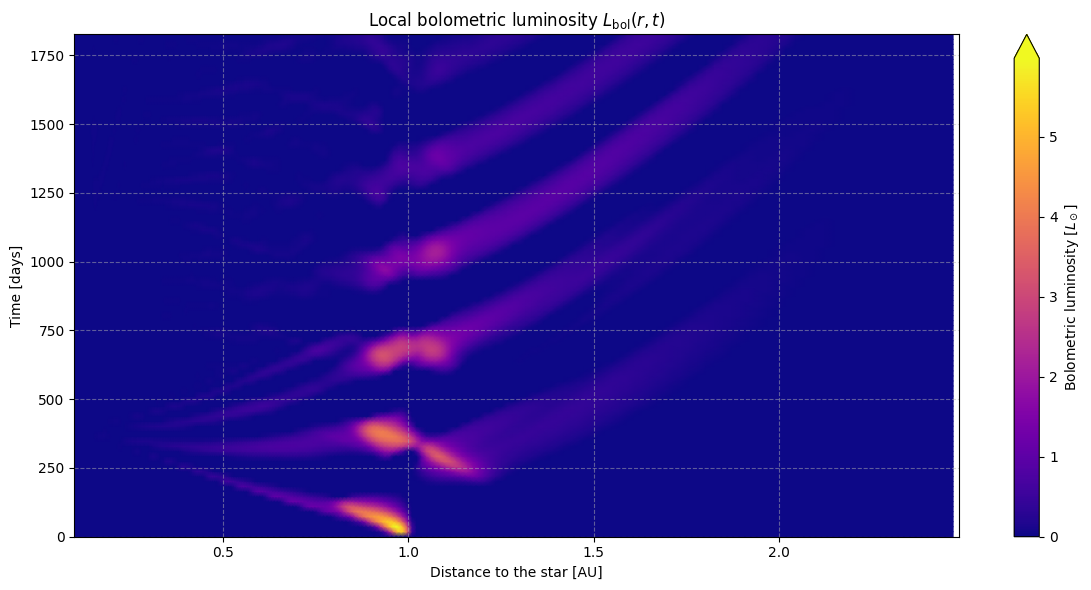

In [111]:
def calcular_luminosidad_bolometrica(mdot_r_cgs, radii_cm, L_sun_cgs):
    """
    Calcula la luminosidad bolométrica en cada radio.
    
    Parámetros:
    - mdot_r_cgs: array de tasas de acreción en g/s para cada radio
    - radii_cm: array de radios en cm
    - L_sun_cgs: luminosidad solar en erg/s
    
    Retorna:
    - Lbol_r: array de luminosidades bolométricas en unidades solares [L_sun] para cada radio
    """
    # Calcular dL/dr para cada radio
    dLdr = (3 * G_cgs * M_star_cgs * mdot_r_cgs) / (2 * (radii_cm ** 2))  # erg/s/cm
    
    # Calcular el ancho de cada bin radial (delta r) en cm
    delta_r_cm = np.diff(radii_cm)
    
    # Calcular L_bol para cada bin radial multiplicando dL/dr por delta r
    # Como np.diff reduce la longitud del array en 1, ajustamos radii_cm_mid
    radii_cm_mid = 0.5 * (radii_cm[:-1] + radii_cm[1:])
    Lbol_r = dLdr[:-1] * delta_r_cm  # erg/s
    
    # Convertir a unidades solares
    Lbol_r_solar = Lbol_r / L_sun_cgs  # [L_sun]
    
    return Lbol_r_solar, radii_cm_mid


# Inicializar una matriz para almacenar L_bol(r, t)
Lbol_matrix = np.zeros((len(time_array), num_radii - 1))  # Dimensiones: tiempo x radio_mid

# Calcular L_bol(r, t) para cada output y radio
for i, output_number in enumerate(output_numbers):
    # Opcional: imprimir progreso
    print(f"Procesando output {output_number + 1} de {Ntot} para tiempo {time_array[i]:.1f} días")
    
    # Calcular \dot{M}(r, t)
    mdot_r = []
    for r0 in radii:
        mdot = compute_accretion_rate(output_number, path, r0)
        mdot_r.append(mdot)
    mdot_r = np.array(mdot_r)
    
    # Convertir \dot{M} a g/s
    mdot_r_cgs = mdot_r * (1.989e33) / (3.154e7)  # g/s
    
    # Establecer a cero los valores negativos de \dot{M}
    mdot_r_cgs = np.where(mdot_r_cgs > 0, mdot_r_cgs, 0.0)
    
    # Calcular L_bol(r, t) en unidades solares
    Lbol_r_solar, radii_cm_mid = calcular_luminosidad_bolometrica(mdot_r_cgs, radii_cm, L_sun_cgs)
    
    # Almacenar en la matriz (ajustar indices debido a np.diff)
    Lbol_matrix[i, :] = Lbol_r_solar

# Crear una malla de radii_mid y tiempos para el plot
R_mid, T_plot = np.meshgrid(radii_cm_mid / unit_length, time_array)  # R_mid en [AU], T_plot en [days]

# Crear la figura y el eje
plt.figure(figsize=(12, 6))

# Usar pcolormesh para el heatmap
pcm = plt.pcolormesh(R_mid, T_plot, Lbol_matrix, shading='gouraud', cmap='plasma')  # Puedes elegir otro cmap si prefieres

# Añadir una barra de colores
cbar = plt.colorbar(pcm, extend='max')
cbar.set_label('Bolometric luminosity [$L_\\odot$]')

# Etiquetas y título
plt.xlabel('Distance to the star [AU]')
plt.ylabel('Time [days]')
plt.title('Local bolometric luminosity $L_{\\text{bol}}(r, t)$')

# Opcional: ajustar los límites del plot
plt.xlim(radii.min(), radii.max())
plt.ylim(time_array.min(), time_array.max())

# Mostrar la cuadrícula
plt.grid(True, linestyle='--', alpha=0.5)

# Ajustar el layout y mostrar el plot
plt.tight_layout()
plt.show()


In [96]:
def cargar_temperature(output_number, path):
    """
    Carga los datos de temperatura para un output específico.
    
    Parámetros:
    - output_number: int, número del snapshot de la simulación
    - path: str, ruta al directorio de datos
    
    Retorna:
    - temp: ndarray, matriz 2D de temperaturas [radial_bins, azimutal_bins] en K
    """
    dens = np.fromfile(path + f"gasdens{output_number}.dat").reshape(NY, NX) * unit_density  # [g/cm^3]
    energy = np.fromfile(path + f"gasenergy{output_number}.dat").reshape(NY, NX) * unit_energy  # [erg/g]
    press = (gamma - 1.0) * energy  # [erg/cm^3]
    
    # Calcula la temperatura en K
    temp = energy / dens / (R_gas / mu) * (gamma - 1)  # [K]
    
    return temp



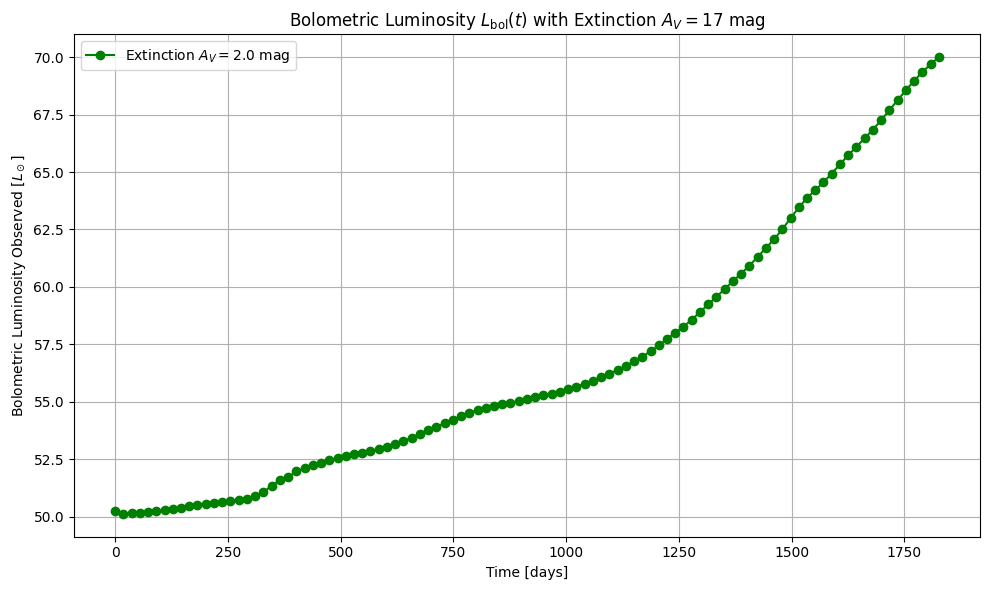

In [97]:
def calcular_luminosidad_bolometrica_temperatura(output_number, path):
    """
    Calcula la luminosidad bolométrica Lbol(t) a partir de la temperatura T(r, t).
    
    Parámetros:
    - output_number: int, número del snapshot de la simulación
    - path: str, ruta al directorio de datos
    
    Retorna:
    - time_days: float, tiempo correspondiente en días
    - Lbol_obs: float, luminosidad bolométrica observada en unidades solares [L_sun]
    """
    # Cargar la temperatura para el output actual
    T = cargar_temperature(output_number, path)  # [radial_bins, azimutal_bins]
    
    # Convertir radios de AU a cm
    radii_cm = radii * unit_length  # [cm]
    
    # Calcular los anchos radiales (delta_r) para la integración
    delta_r_cm = np.diff(radii_cm)  # [cm], longitud num_radii - 1
    
    # Calcular los puntos medios de cada bin radial
    radii_cm_mid = 0.5 * (radii_cm[:-1] + radii_cm[1:])  # [cm], longitud num_radii - 1
    
    # Promediar la temperatura sobre la dimensión azimutal (axis=1)
    T_avg = np.mean(T, axis=1)  # [radial_bins]
    
    # Alinear las dimensiones: radii_cm_mid y T_avg tienen longitud num_radii - 1
    T_avg_mid = 0.5 * (T_avg[:-1] + T_avg[1:])  # Promedio entre puntos radiales, longitud num_radii - 1
    
    # Calcular la contribución local a la luminosidad bolométrica
    dLdr = 4 * np.pi * radii_cm_mid * sigma_sb * T_avg_mid**4  # [erg/s/cm]
    
    # Integrar sobre el radio para obtener Lbol(t)
    Lbol = np.sum(dLdr * delta_r_cm)  # [erg/s]
    
    # Convertir a unidades solares
    Lbol_solar = Lbol / L_sun_cgs  # [L_sun]
    
    # Aplicar extinción para obtener la luminosidad observada
    Lbol_obs = Lbol_solar * 10**(-0.4 * A_V)  # [L_sun]
    
    # Calcular el tiempo correspondiente en días
    # Asumiendo que 'output_number' comienza en 0
    time_code_units = output_number * Ninter * DT
    time_days = time_code_units * unit_time / 86400  # [days]
    
    return time_days, Lbol_obs

# Supongamos que tienes una lista o array de output_numbers
# Por ejemplo:
# output_numbers = range(0, 100)  # 100 snapshots

# Define la ruta a los datos

# Inicializar listas para almacenar los resultados
time_array_Lbol = []
Lbol_total_obs = []

# Iterar sobre cada output_number para calcular L_bol(t)
for output_number in output_numbers:
    # Calcular tiempo y Lbol_obs usando la función definida
    time_days, Lbol_obs = calcular_luminosidad_bolometrica_temperatura(
        output_number, path
    )
    
    # Almacenar los resultados
    time_array_Lbol.append(time_days)
    Lbol_total_obs.append(Lbol_obs)

# Convertir las listas a arrays de numpy para facilitar el manejo
time_array_Lbol = np.array(time_array_Lbol)
Lbol_total_obs = np.array(Lbol_total_obs)

# Graficar la luminosidad bolométrica observada vs. tiempo
plt.figure(figsize=(10, 6))
plt.plot(time_array_Lbol, Lbol_total_obs, marker='o', color='green', label=f'Extinction $A_V={A_V}$ mag')
plt.xlabel('Time [days]')
plt.ylabel('Bolometric Luminosity Observed [$L_\\odot$]')
plt.title('Bolometric Luminosity $L_{\\text{bol}}(t)$ with Extinction $A_V=17$ mag')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [98]:
for i, output_number in enumerate(output_numbers[:5]):  # Ver los primeros 5 outputs
    time_days, Lbol_obs = calcular_luminosidad_bolometrica_temperatura(output_number, path)
    print(f"Output {output_number}: Time = {time_days} days, Lbol_obs = {Lbol_obs} L_sun")


Output 0: Time = 0.0 days, Lbol_obs = 50.24984074995001 L_sun
Output 1: Time = 18.2620396976089 days, Lbol_obs = 50.114793618557876 L_sun
Output 2: Time = 36.5240793952178 days, Lbol_obs = 50.13851776340664 L_sun
Output 3: Time = 54.786119092826695 days, Lbol_obs = 50.16422265551404 L_sun
Output 4: Time = 73.0481587904356 days, Lbol_obs = 50.1916547591951 L_sun


In [99]:
# Ejemplo de depuración para los primeros 5 outputs
for i, output_number in enumerate(output_numbers[:5]):
    time_days, Lbol_obs = calcular_luminosidad_bolometrica_temperatura(output_number, path)
    print(f"Output {output_number}: Time = {time_days} days, Lbol_obs = {Lbol_obs:.2f} L_sun")


Output 0: Time = 0.0 days, Lbol_obs = 50.25 L_sun
Output 1: Time = 18.2620396976089 days, Lbol_obs = 50.11 L_sun
Output 2: Time = 36.5240793952178 days, Lbol_obs = 50.14 L_sun
Output 3: Time = 54.786119092826695 days, Lbol_obs = 50.16 L_sun
Output 4: Time = 73.0481587904356 days, Lbol_obs = 50.19 L_sun


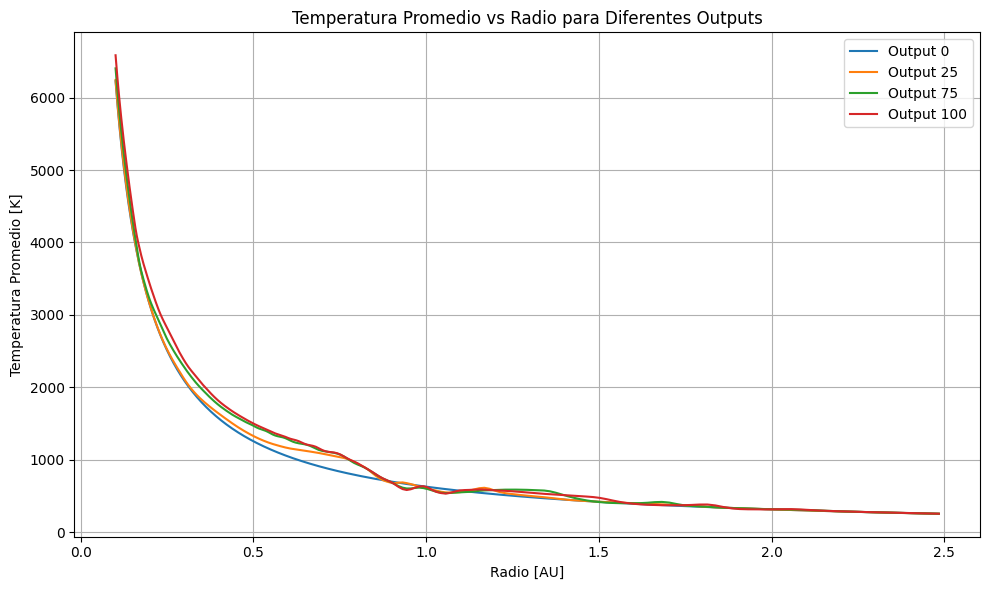

In [100]:
import matplotlib.pyplot as plt

def plot_T_avg_for_outputs(output_numbers):
    """
    Plotea la temperatura promedio T_avg vs radio para una lista de output_numbers.
    
    Parámetros:
    - output_numbers: list o array de int, números de outputs a plotear
    
    Retorna:
    - None
    """
    plt.figure(figsize=(10, 6))
    
    for output_number in output_numbers:
        # Cargar la temperatura para el output actual
        T = cargar_temperature(output_number, path)  # [radial_bins, azimutal_bins]
        
        # Promediar la temperatura sobre la dimensión azimutal (axis=1)
        T_avg = T.mean(axis=1)  # [radial_bins]
        
        # Plotea T_avg vs radii (en AU)
        plt.plot(radii, T_avg, label=f'Output {output_number}')
    
    plt.xlabel('Radio [AU]')
    plt.ylabel('Temperatura Promedio [K]')
    plt.title('Temperatura Promedio vs Radio para Diferentes Outputs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
# Define una lista de output_numbers que deseas plotear
output_numbers_to_plot = [0, 25, 75, 100]  # Ajusta según tus outputs disponibles

# Llamar a la función para generar el plot
plot_T_avg_for_outputs(output_numbers_to_plot)
